# JWST NIRCam SIRS Correction

Bernard J. Rauscher<br>
NASA Goddard Space Flight Center, Greenbelt, MD 20771

29 July 2021

This example shows how to SIRS correct JWST NIRCam full-frame data using a previously computed SIRS calibration file.

In [1]:
# Standard python packages
from glob import glob
from astropy.io import fits
import numpy as np
from os import getenv
from PIL import Image

import sirspy

In [2]:
# Instantiate a SIRS object
sirs = sirspy.SIRS(getenv('HOME') + '/Library/JWST/NIRCam/20151217_nircam_sirs.h5')

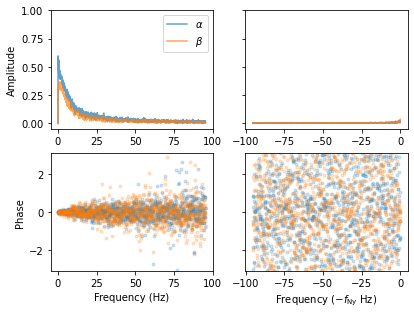

In [3]:
# Make some plots to show that it imported correctly. NIRCam's outputs are
# numbered 0-3 in SIRS.
output = 1 # Select an output
sirs.plot(output); # Plot it

In [4]:
# Just look at one
ddir = '/local/data/racy1/brausche/JWST/NIRCam/'
file = glob(ddir+'*.fits')[-1];

In [5]:
# Read in data 
with fits.open(file) as hdul:
    D_sirs = np.float64(hdul[0].data)
D_rows = D_sirs.copy() # Make a copy for rowsonly correction to compare

In [6]:
# Reference correct in place. This overwrites the input data.
sirs.refcor(D_sirs)                # SIRS correction
sirs.refcor(D_rows, rowsonly=True) # Rows only

Fit straight lines using Legendre polynomials. If $s$ is signal and $z$ is up-the-ramp sample index projected to the range over which the Legendre polynomials are defined, the following fits,

<center>$s(z) = \lambda_0 P_0(z) + \lambda_1 P_1(z)\hspace{18pt}(1)$,</center>

where $P_m(z)$ are the Legendre polynomials. The integrated charge during the exposure is give by $2\lambda_1$. One could equivalently fit,

<center>$s(z) = a_0 z^0 + a_1 z^1\hspace{18pt}(2)$,</center>

but I already have the tools to efficiently do Legendre fitting.

In [7]:
# Fit integrated counts. The units are DN. For the SIRS image, the median value is about 21 DN.
Λ = sirspy.Legendre(108,1) # 108 frames, 1st degree Legendre fit

# SIRS
sirs_cnts = 2*Λ.legfit(D_sirs)[1] # Integrated counts in DN

# Rows only
rows_cnts = 2*Λ.legfit(D_rows)[1] # ...

In [8]:
# Save
fits.PrimaryHDU(sirs_cnts).writeto(getenv('HOME')+'/tmp/sirs.fits', overwrite=True)
fits.PrimaryHDU(rows_cnts).writeto(getenv('HOME')+'/tmp/rows.fits', overwrite=True)

For presentation purposes, make a PNG that compares the lower-left corner.

In [9]:
# Extract region of interest
roi = np.zeros((1080,1920), dtype=np.float)
roi[:1080,:1920//2] = rows_cnts[:1080,:1920//2]
roi[:1080,1920//2:] = np.fliplr(sirs_cnts[:1080,:1920//2])

In [10]:
# Scale it for PNG

# Grey range of interest
μ = np.median(roi)
min,max = μ-2.5,μ+2.5

# Scale it
roi[roi<min] = min
roi[roi>max] = max
roi -= min
roi /= roi.max()
roi = np.uint8(255*roi)

# Make separator line
roi[:,1920//2-2:1920//2+3] = 255

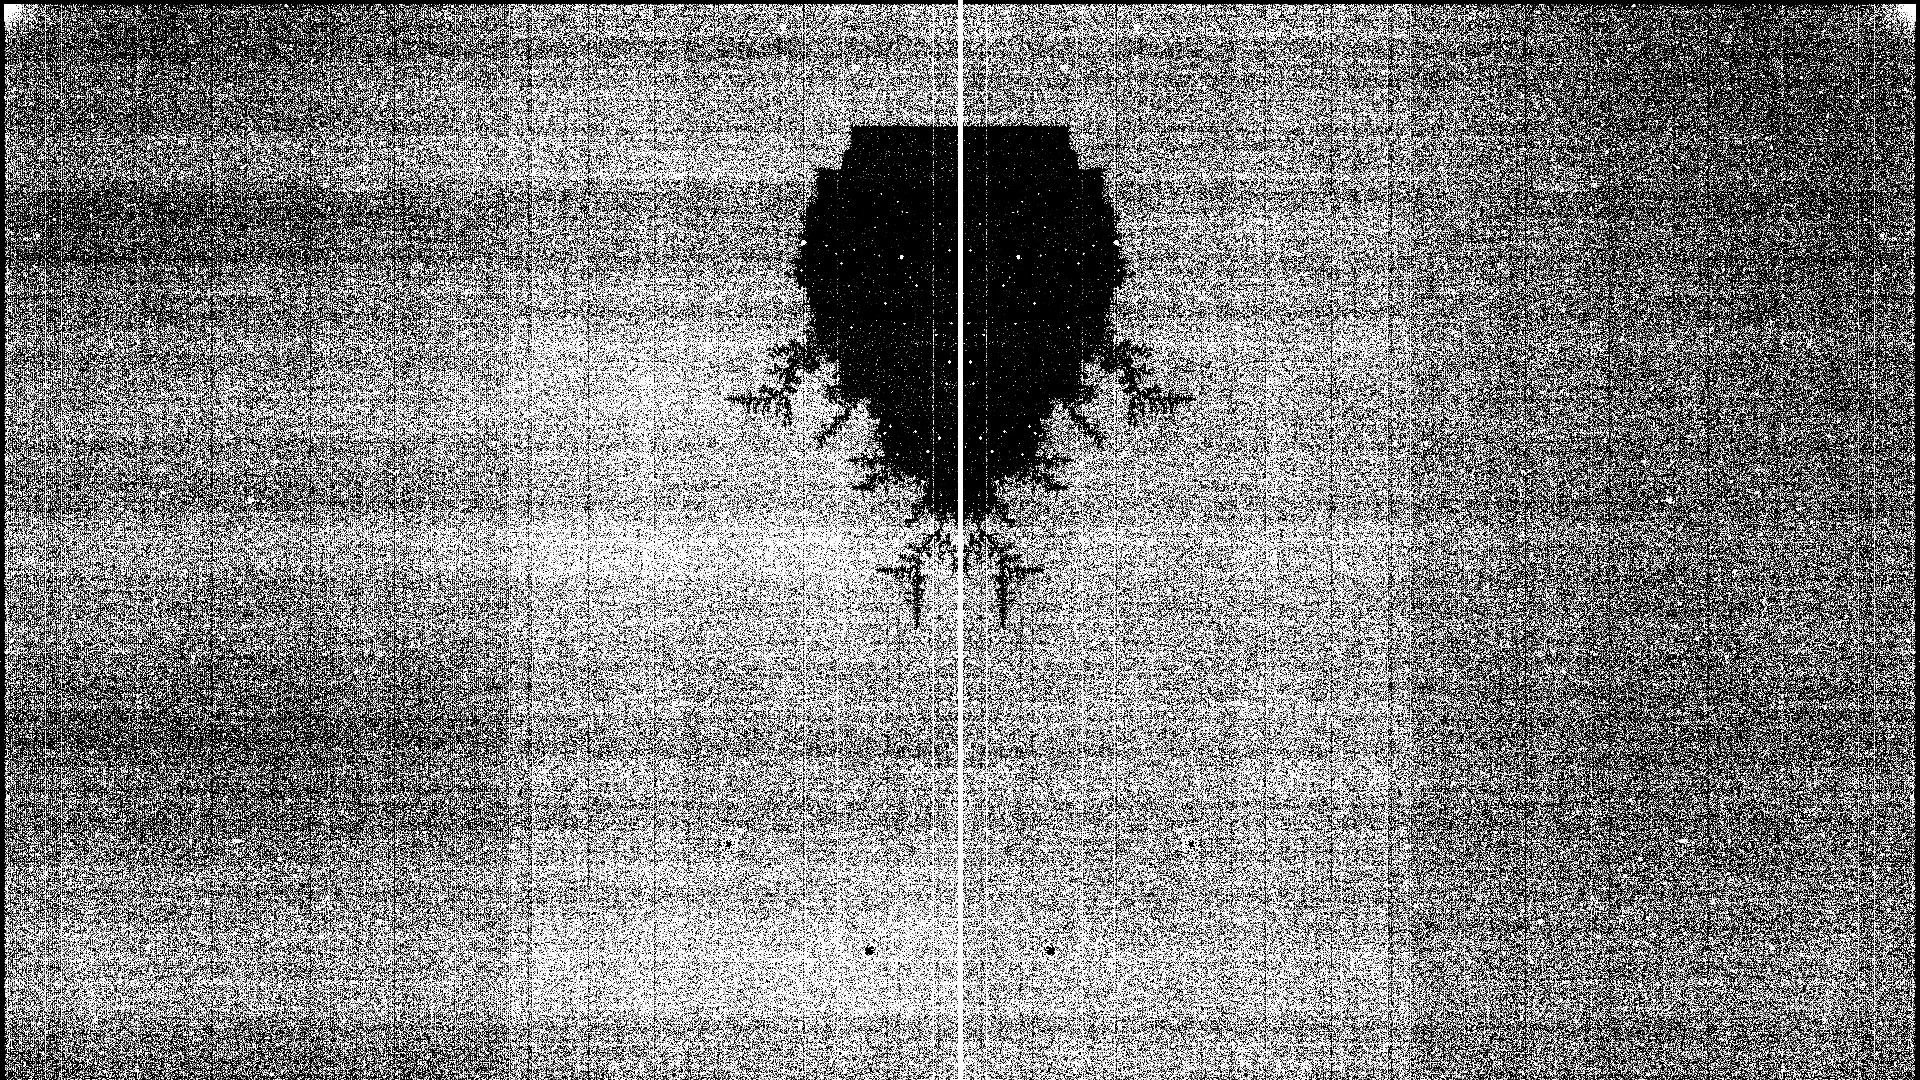

In [11]:
# Make image
im = Image.fromarray(roi)

# Save it
im.save(getenv('HOME')+'/tmp/20210729_nircam_comparison.png')

# Display it
im